This notebook take pre trained model and fine tune it on a new Dataset

### I. Librairies

In [1]:
import tensorflow as tf
print('tensorflow version:',tf.__version__)
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

tensorflow version: 2.1.0
Num GPUs Available: 1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

In [3]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import model_from_json

In [4]:
%matplotlib inline
random_state = 42
np.random.seed(random_state)

### II. Data Loading

In [5]:
data = pd.read_csv("Data/font_generated_data.csv",header=None)
X = data.iloc[:,1:].values
X = X.reshape(X.shape[0], 28, 28)
y = data.iloc[:,0].values
print(f"X shape: {X.shape}")
print(f"Y shape: {y.shape}")

X shape: (45360, 28, 28)
Y shape: (45360,)


##### II.d Normalisation and reshaping

In [6]:
X = X / 255
X = X.reshape(X.shape[0], 28, 28, 1) #for keras

##### II.e Display

In [7]:
def labelToChar(label):
    if label < 10:
        return chr(label + 48)
    return chr(label + 55)

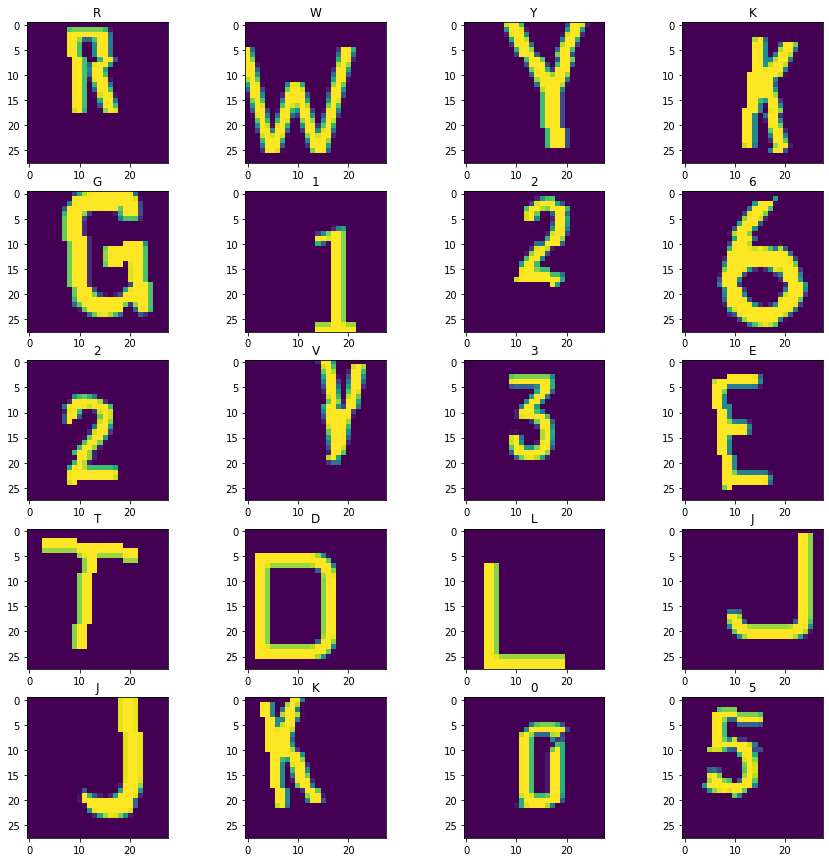

In [9]:
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    i_img = np.random.randint(0, X.shape[0])
    plt.imshow(np.array(X[i_img]).reshape(28,28))
    plt.title(labelToChar(y[i_img]))
plt.show()

##### II.f Set separation

In [10]:
y_cat=to_categorical(y)

X_train, X_validation, y_train, y_validation = train_test_split(X, y_cat, train_size = 0.7,
                                                                random_state = random_state,
                                                                stratify = y_cat, shuffle = True)
X_validation, X_test, y_validation, y_test = train_test_split(X_validation, y_validation, train_size = 0.6,
                                                                random_state = random_state,
                                                                stratify = y_validation, shuffle = True)
print(f"Train/Validation/Test size: {X_train.shape[0]}/{X_validation.shape[0]}/{X_test.shape[0]}")

Train/Validation/Test size: 31751/8165/5444


### III. Model Loading

In [11]:
model_name = "character_model"
folder = 'Models/'

# load json and create model
json_file = open(f"{folder}{model_name}.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(f"{folder}{model_name}.h5")
print("Loaded model from disk")
 
# compile the model to be able to use it
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Loaded model from disk


### III.Training

In [13]:
model.fit(X_train, y_train, batch_size = 256, epochs = 1, validation_data = (X_validation, y_validation))

Train on 31751 samples, validate on 8165 samples
31751/31751 [==============================] - 4s 129us/sample - loss: 0.0169 - accuracy: 0.9936 - val_loss: 0.0149 - val_accuracy: 0.9933


### IV. Test

In [14]:
loss, accuracy = model.evaluate(X_train, y_train, verbose = 0)
print(f"Train loss: {loss:.3f} Train accuracy: {100*accuracy:.2f}")
loss, accuracy = model.evaluate(X_validation, y_validation, verbose = 0)
print(f"Validation loss: {loss:.3f} Validation accuracy: {100*accuracy:.2f}")
loss, accuracy = model.evaluate(X_test, y_test, verbose = 0)
print(f"Test loss: {loss:.3f} Test accuracy: {100*accuracy:.2f}")

Train loss: 0.009 Train accuracy: 99.61
Validation loss: 0.015 Validation accuracy: 99.33
Test loss: 0.016 Test accuracy: 99.38


### V. Save model

In [15]:
model_name = "fine_character_model"
folder = 'Models/'

# serialize model to JSON
model_json = model.to_json()
with open(f"{folder}{model_name}.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(f"{folder}{model_name}.h5")
print("Saved model to disk")

Saved model to disk


### VI. Convert Model to TfLite

In [16]:
model_name = "fine_character_model"
folder = 'Models/'
converter = tf.lite.TFLiteConverter.from_keras_model(model)# Convert the model
tflite_model = converter.convert()# Create the tflite model file
open(f"{folder}{model_name}.tflite", "wb").write(tflite_model)

4535764

In [17]:
with open('Models/labels.txt', 'w') as f:
    for i in range(y_train.shape[1]):
        f.write(labelToChar(i) + '\n')

### VII Load a saved Model

##### VII.a load keras model

In [20]:
model_name = "character_model"
folder = 'Models/'

# load json and create model
json_file = open(f"{folder}{model_name}.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(f"{folder}{model_name}.h5")
print("Loaded model from disk")
 
# compile the model to be able to use it
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Loaded model from disk


##### VII.b load a tflite model

In [17]:
model_name = "fine_character_model"
folder = 'Models/'
interpreter = tf.lite.Interpreter(model_path=f"{folder}{model_name}.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

### VIII Check tflite conversion

In [18]:
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[2.6380289e-06 7.2452281e-08 3.5482483e-06 2.1456324e-03 2.7680022e-04
  3.0808875e-04 3.0241779e-04 2.1804759e-08 7.7959329e-01 2.0932712e-02
  2.3924271e-09 1.8924037e-01 7.4192574e-10 3.0353465e-07 1.7615495e-06
  4.8014748e-10 7.1344776e-03 7.3335073e-06 9.1732275e-09 1.0628563e-10
  1.4172222e-10 7.0166086e-09 3.3312391e-12 1.7757546e-14 3.2392531e-08
  1.1131222e-11 4.5142504e-05 6.4582267e-08 1.0930713e-06 5.0761505e-13
  5.6335345e-08 2.4772377e-13 6.7004088e-08 1.6223502e-11 1.2296887e-11
  4.0652826e-06]]


In [19]:
i_img = np.random.randint(0, X_test.shape[0])
out = model.predict(input_data)
print(out)

[[2.6380235e-06 7.2452067e-08 3.5482374e-06 2.1456247e-03 2.7679981e-04
  3.0808727e-04 3.0241729e-04 2.1804778e-08 7.7959394e-01 2.0932628e-02
  2.3924200e-09 1.8923981e-01 7.4192213e-10 3.0353374e-07 1.7615477e-06
  4.8014698e-10 7.1344664e-03 7.3334918e-06 9.1732000e-09 1.0628491e-10
  1.4172179e-10 7.0165740e-09 3.3312168e-12 1.7757493e-14 3.2392432e-08
  1.1131188e-11 4.5142369e-05 6.4582196e-08 1.0930692e-06 5.0761359e-13
  5.6335068e-08 2.4772255e-13 6.7003889e-08 1.6223486e-11 1.2296873e-11
  4.0652744e-06]]


In [20]:
print(f"total error: {np.sum(out - output_data)}")

total error: -9.371614595465871e-10
